In [2]:
import os
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split

# Generator to load data in batches
def load_data_in_batches(patient_list, batch_size):
    while True:
        np.random.shuffle(patient_list)
        
        for i in range(0, len(patient_list), batch_size):
            batch_patients = patient_list[i:i+batch_size]
            images, masks = [], []
            
            for patient in batch_patients:
                patient_path = os.path.join('Data/BraTS2021', patient)
                
                flair_path = os.path.join(patient_path, f'{patient}_flair.nii')
                t1ce_path = os.path.join(patient_path, f'{patient}_t1ce.nii')
                t2_path = os.path.join(patient_path, f'{patient}_t2.nii')
                seg_path = os.path.join(patient_path, f'{patient}_seg.nii')
                
                # Load the images using nibabel
                flair = nib.load(flair_path).get_fdata()
                t1ce = nib.load(t1ce_path).get_fdata()
                t2 = nib.load(t2_path).get_fdata()
                seg = nib.load(seg_path).get_fdata()
                
                # Stack the modalities (flair, t1ce, t2) along the channel axis
                stacked_image = np.stack([flair, t1ce, t2], axis=-1)
                
                images.append(stacked_image)
                masks.append(seg)
            
            # Convert to numpy arrays and normalize
            images = np.array(images)
            # masks = np.array(masks)
            # Adjust the mask to have a channel dimension at the end
            masks = np.expand_dims(masks, axis=-1)

            
            images = images / np.max(images)  # Normalize images
            masks = masks / np.max(masks)  # Normalize masks
            
            yield images, masks


In [3]:
# List of patients
patients = os.listdir('Data/BraTS2021')

# Split into training and validation sets
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Set batch size
batch_size = 2  # Adjust batch size depending on memory


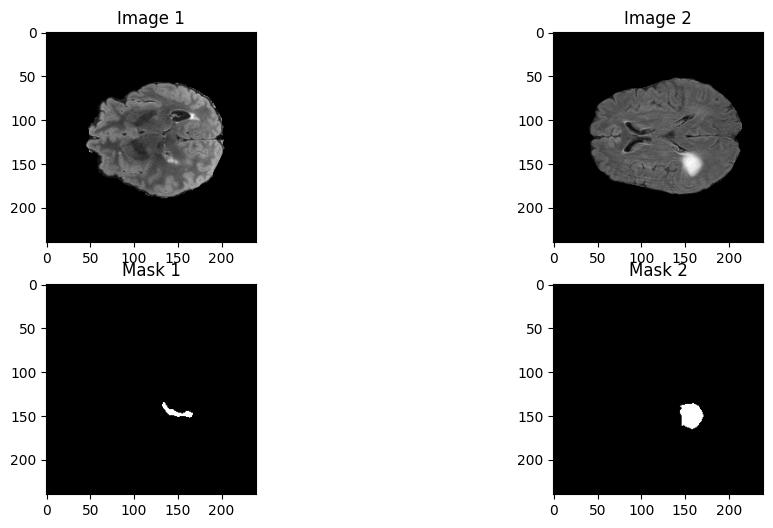

In [5]:
import matplotlib.pyplot as plt

# Load a batch from the training set
train_generator = load_data_in_batches(train_patients, batch_size)

# Get one batch of images and masks
images, masks = next(train_generator)

# Visualize some of the images and masks
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for i in range(2):
    axes[0, i].imshow(images[i, :, :, images.shape[3]//2, 0], cmap='gray')
    axes[0, i].set_title(f"Image {i+1}")
    axes[1, i].imshow(masks[i, :, :, masks.shape[3]//2], cmap='gray')
    axes[1, i].set_title(f"Mask {i+1}")
plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 2

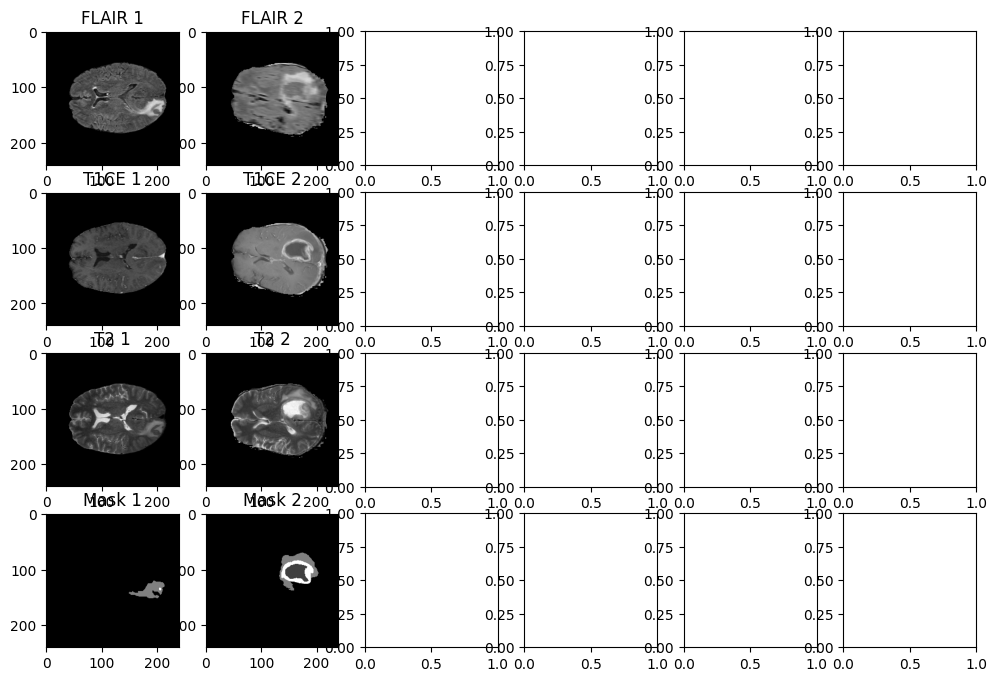

In [6]:
import matplotlib.pyplot as plt

# Load a batch from the training set
train_generator = load_data_in_batches(train_patients, batch_size)

# Get one batch of images and masks
images, masks = next(train_generator)

# Visualize different modalities for a few samples
fig, axes = plt.subplots(4, 6, figsize=(12, 8))
for i in range(6):
    # FLAIR modality
    axes[0, i].imshow(images[i, :, :, images.shape[3]//2, 0], cmap='gray')
    axes[0, i].set_title(f"FLAIR {i+1}")
    
    # T1CE modality
    axes[1, i].imshow(images[i, :, :, images.shape[3]//2, 1], cmap='gray')
    axes[1, i].set_title(f"T1CE {i+1}")
    
    # T2 modality
    axes[2, i].imshow(images[i, :, :, images.shape[3]//2, 2], cmap='gray')
    axes[2, i].set_title(f"T2 {i+1}")
    
    # Segmentation mask
    axes[3, i].imshow(masks[i, :, :, masks.shape[3]//2], cmap='gray')
    axes[3, i].set_title(f"Mask {i+1}")
    
plt.tight_layout()
plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
def create_fcn_3d(input_shape):
    model = models.Sequential()

    # 1st Convolutional Block
    model.add(layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))

    # 2nd Convolutional Block
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'))

    # 3rd Convolutional Block
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'))

    # Output layer
    model.add(layers.Conv3D(1, (1, 1, 1), activation='sigmoid', padding='same'))  # Binary mask output

    return model

# Define input shape
input_shape = (240, 240, 155, 3)
model = create_fcn_3d(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


2024-10-05 17:01:12.833560: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-05 17:01:12.840023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 17:01:12.848064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 17:01:12.850616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 17:01:12.857412: I tensorflow/core/platform/cpu_feature_guar

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 240, 240, 155,  │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 240, 240, 155,  │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 240, 240, 155,  │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 240, 240, 155,  │           129 │
│                                 │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,425 (1.07 MB)

 Trainable params: 279,425 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Define the training data generator
train_generator = load_data_in_batches(train_patients, batch_size)

# Define the validation data generator (you may want to modify the loading logic)
val_generator = load_data_in_batches(val_patients, batch_size)


In [9]:
# Set epochs and steps
epochs = 1  # Adjust as necessary
train_steps = len(train_patients) // batch_size
val_steps = len(val_patients) // batch_size

# Train the model
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=epochs
)




: 